## Convolutional Neural Network for Image Classfication of Brain MRIs by Dementia Severity
by Eli Taylor

### Load Libraries and Packages

In [35]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_sample_weight

import tensorflow as tf

from tensorflow import keras
from keras.layers import Conv2D, Dense, MaxPooling2D, Rescaling, Flatten, Dropout
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy

### Load labels

I've already downloaded the CSV from the data source, cleaned it, and formatted into a dataframe of labels with image file names.

In [42]:
oasis_image_labels = pd.read_csv('MSDA_Capstone_Labels_Cleaned.csv')

In [43]:
# CDR = Clinical Dementia Rating

oasis_image_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       436 non-null    int64  
 1   CDR              436 non-null    float64
 2   Image_file_name  436 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 10.3+ KB


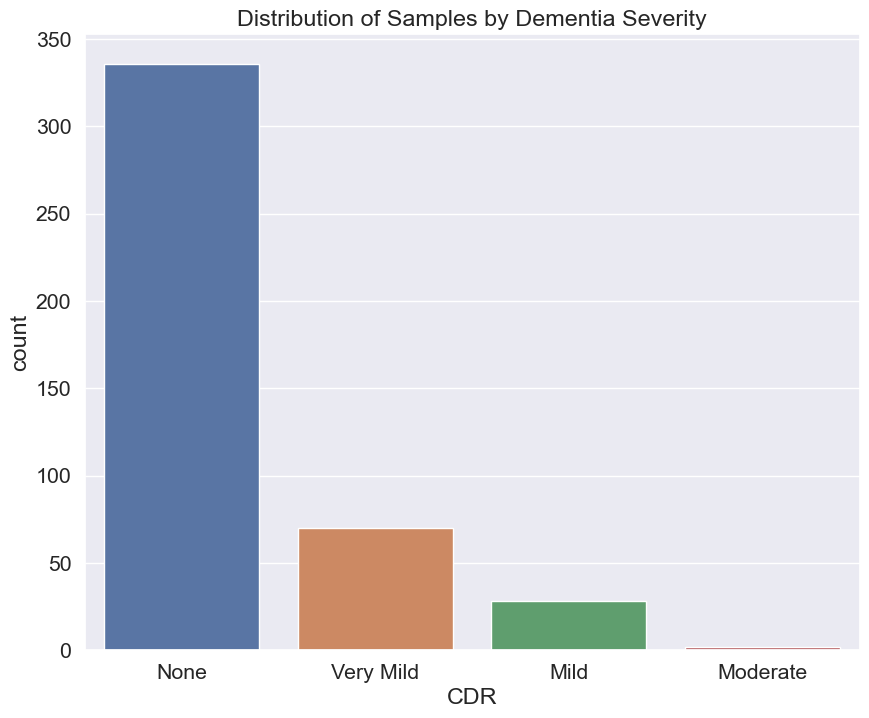

<Figure size 1200x1200 with 0 Axes>

In [80]:
plot = plt.subplots(figsize=(10, 8))
plot = sns.countplot(data=oasis_image_labels, x='CDR')
plt.title('Distribution of Samples by Dementia Severity')
plot.set_xticks(range(4), labels=['None', 'Very Mild', 'Mild', 'Moderate'])
plt.show()
plt.clf()

### Load Image Data
My first attempt was using the OASIS-1 dataset from the OASIS brains project website (http://www.oasis-brains.org/). This dataset is free to download and intended for neuroscience research. It contains brain MRI images from 436 participants which are classified by dementia severity as either No Dementia, Very Mild Dementia, Mild Dementia, or Moderate Dementia. 

In [61]:
image_size = (180, 180)
batch_size = 64

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "MSDA_Capstone_Train_Test_Data_Vol2/",
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 432 files belonging to 4 classes.
Using 346 files for training.
Using 86 files for validation.


### Image Examples
CODE SOURCE: https://keras.io/examples/vision/image_classification_from_scratch/

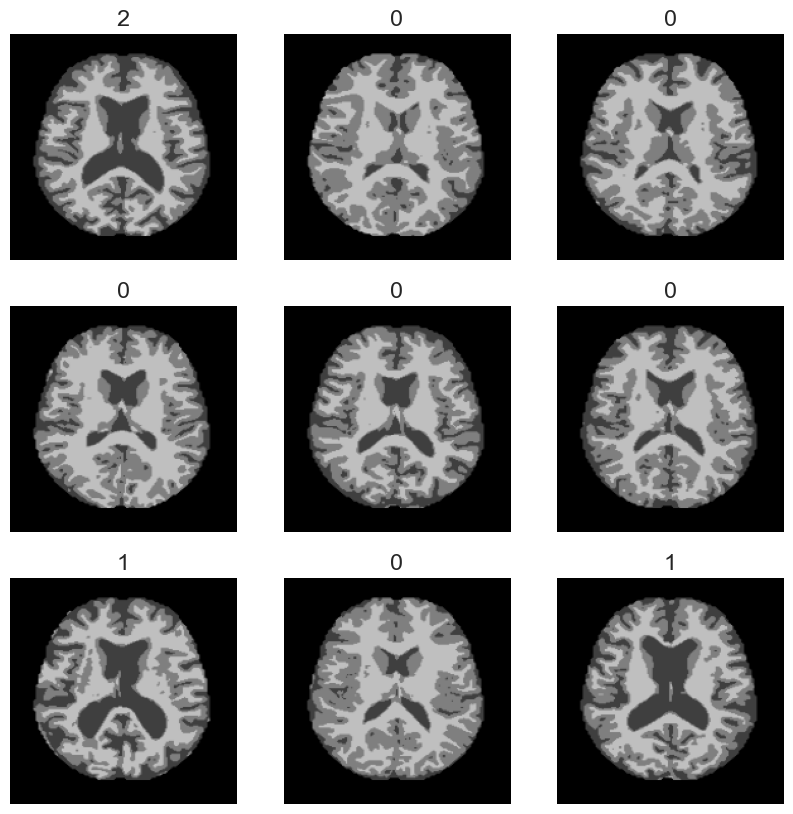

In [62]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Get Sample Weights
This helps compensate for the unbalanced classes in the dataset.

CODE SOURCE: https://medium.com/grabngoinfo/neural-network-model-balanced-weight-for-imbalanced-classification-in-keras-68d7b6c1462c \
https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_sample_weight.html

In [47]:
#get labels from training set

train_label = np.concatenate([y for x, y in train_ds], axis=0)
np.unique(train_label, return_counts=True)

(array([0, 1, 2, 3]), array([269,  57,  22,   1], dtype=int64))

In [48]:
sample_weights = compute_sample_weight(class_weight='balanced', y=train_label)

In [49]:
sample_weights_dict = dict(enumerate(sample_weights))

### Initialize and Compile Model
Convolutional Neural Network models are widely preferred for image classification tasks.

CODE SOURCE: https://www.tensorflow.org/tutorials/images/classification \
https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

In [41]:
# Initialize the Sequential API and start stacking the layers
model = Sequential()

# rescale images for neural network
model.add(Rescaling(1./255, input_shape=(180, 180, 3)))

# add the convolutional layers
# typically the number of filters increases in each layer
model.add(Conv2D(32, (3,3), padding='same', activation='relu', use_bias=True, kernel_initializer='he_normal'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())

# dropout layer helps reduce overfitting
model.add(Dropout(0.3))

# add dense (fully connected) layers
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(4))

# select appropriate output layer for multi-category classification
# compile model
model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [63]:
# fit and validate model
model_history = model.fit(train_ds, 
          validation_data= (val_ds), 
          epochs= 50,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
          class_weight=sample_weights_dict
          )

Epoch 1/50
6/6 [==============================] - 6s 1s/step - loss: 0.5126 - accuracy: 0.7081 - val_loss: 0.7549 - val_accuracy: 0.7907
Epoch 2/50
6/6 [==============================] - 6s 1s/step - loss: 0.4428 - accuracy: 0.7399 - val_loss: 0.6632 - val_accuracy: 0.7791
Epoch 3/50
6/6 [==============================] - 6s 973ms/step - loss: 0.4427 - accuracy: 0.7688 - val_loss: 0.8412 - val_accuracy: 0.7674
Epoch 4/50
6/6 [==============================] - 6s 1s/step - loss: 0.4204 - accuracy: 0.7803 - val_loss: 0.7761 - val_accuracy: 0.7558
Epoch 5/50
6/6 [==============================] - 6s 1s/step - loss: 0.3782 - accuracy: 0.7457 - val_loss: 0.6086 - val_accuracy: 0.7674
Epoch 6/50
6/6 [==============================] - 6s 1s/step - loss: 0.4673 - accuracy: 0.7572 - val_loss: 0.7380 - val_accuracy: 0.7791
Epoch 7/50
6/6 [==============================] - 6s 1s/step - loss: 0.4308 - accuracy: 0.7832 - val_loss: 0.9048 - val_accuracy: 0.6977
Epoch 8/50
6/6 [======================

### Visualize Results

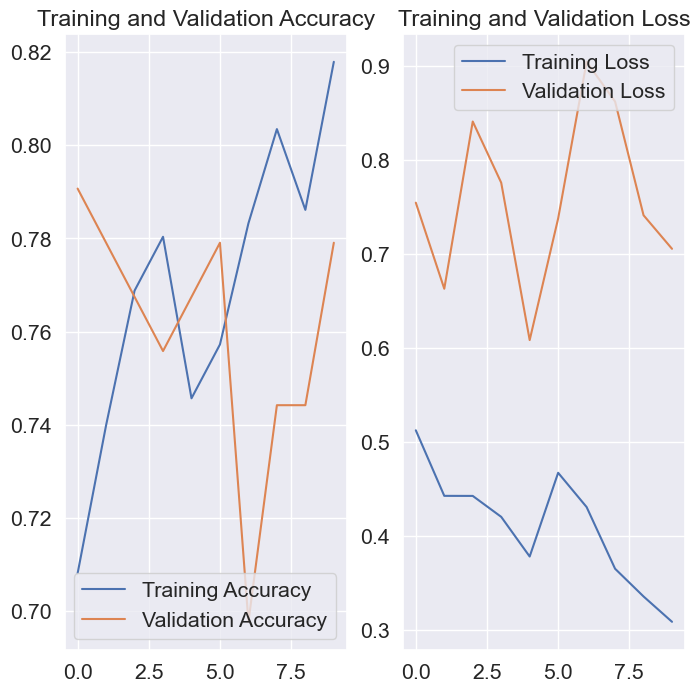

In [65]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Plot a Confusion Matrix

This will show which categories the model is predicting correctly or incorrectly.

In [66]:
def get_actual_predicted_labels(dataset): 
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [67]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)

2/2 [==============================] - 0s 113ms/step


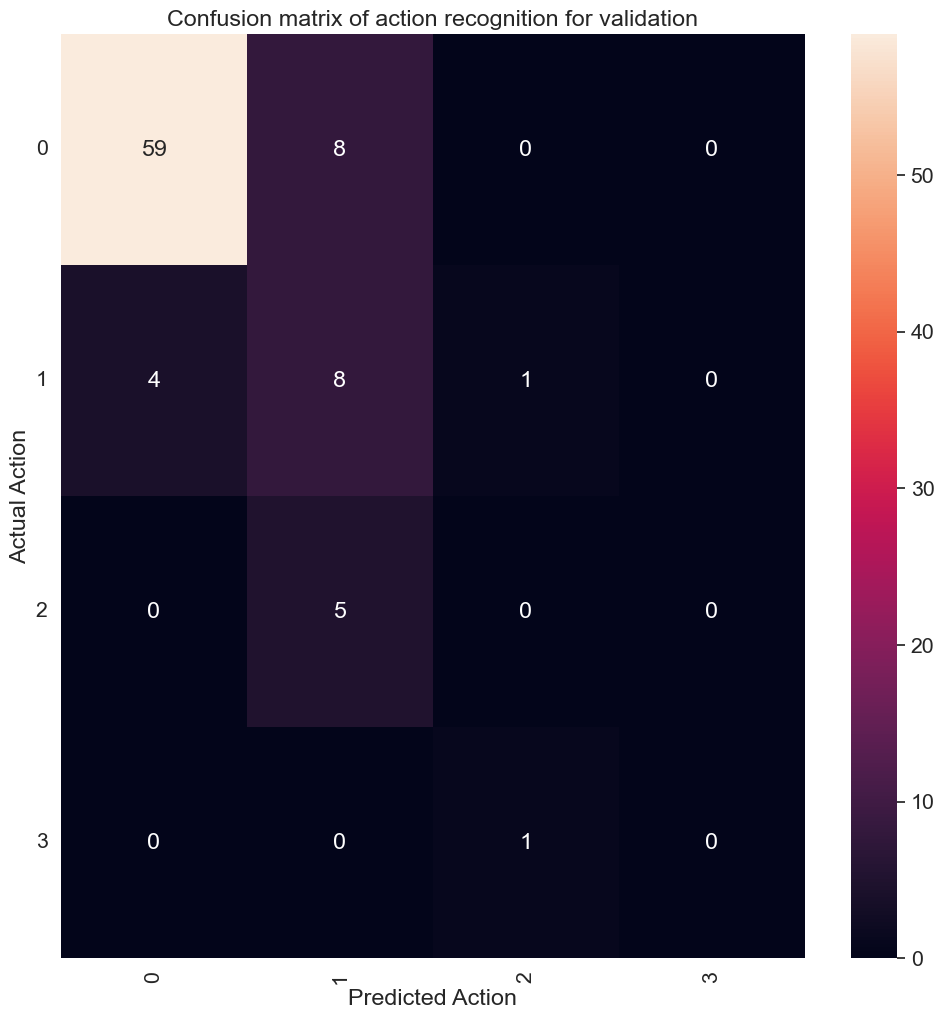

In [68]:
val_label = np.concatenate([y for x, y in val_ds], axis=0)
actual, predicted = get_actual_predicted_labels(val_ds)
plot_confusion_matrix(actual, predicted, np.unique(val_label), 'validation')

### Evaluation
Despite a lot of tuning, adding layers, training for more epochs, the model is only able to achieve a maximum of about 78% on validation data with this dataset. 

This is a pretty small dataset and ideally we need a much larger amount of data for training to get better results. Fortunately, there is a much bigger free and preprocessed dataset on Kaggle with MRI images for this same type of project!

SOURCE: https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset

### Load Kaggle image data

In [69]:
image_size = (180, 180)
batch_size = 64

train_ds2, val_ds2 = tf.keras.utils.image_dataset_from_directory(
    "Kaggle_MRI_Dataset/",
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Using 1280 files for validation.


### View Example Images

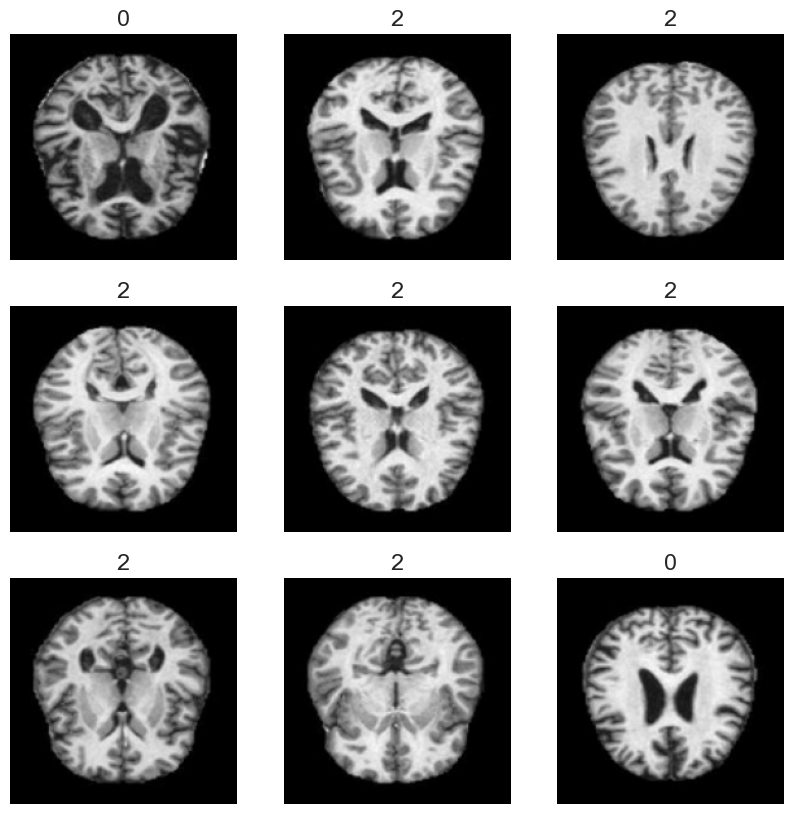

In [70]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds2.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Let's see what results we get with 6400 images.

### Calculate new sample weights

In [71]:
#get labels from training set

train_label2 = np.concatenate([y for x, y in train_ds2], axis=0)
np.unique(train_label2, return_counts=True)

(array([0, 1, 2, 3]), array([ 736,   48, 2557, 1779], dtype=int64))

In [72]:
sample_weights2 = compute_sample_weight(class_weight='balanced', y=train_label2)

In [73]:
sample_weights_dict2 = dict(enumerate(sample_weights2))

### Distribution of Kaggle Dataset
Definitely still need to balance the dataset.

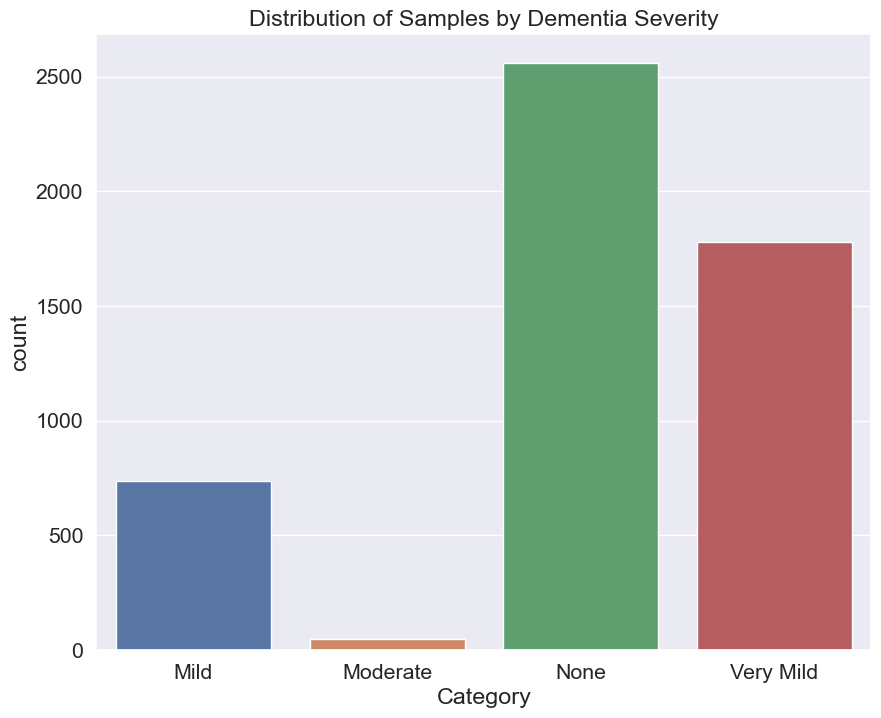

<Figure size 1200x1200 with 0 Axes>

In [77]:
kaggle_image_labels_df = pd.DataFrame(train_label2, columns=['Category'])

plot = plt.subplots(figsize=(10, 8))
plot = sns.countplot(data=kaggle_image_labels_df, x='Category')
plt.title('Distribution of Samples by Dementia Severity')
plot.set_xticks(range(4), labels=['Mild', 'Moderate', 'None', 'Very Mild'])
plt.show()
plt.clf()

### Fit and Validate Same CNN Model with More Data

In [81]:
model2_history = model.fit(train_ds2, 
          validation_data= (val_ds2), 
          epochs= 50,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
          class_weight=sample_weights_dict2
          )

Epoch 1/50
80/80 [==============================] - 99s 1s/step - loss: 1.8971 - accuracy: 0.5246 - val_loss: 0.8937 - val_accuracy: 0.5867
Epoch 2/50
80/80 [==============================] - 93s 1s/step - loss: 1.4951 - accuracy: 0.6002 - val_loss: 0.7905 - val_accuracy: 0.6531
Epoch 3/50
80/80 [==============================] - 95s 1s/step - loss: 1.3130 - accuracy: 0.6584 - val_loss: 0.6901 - val_accuracy: 0.7031
Epoch 4/50
80/80 [==============================] - 96s 1s/step - loss: 1.1048 - accuracy: 0.7189 - val_loss: 0.5583 - val_accuracy: 0.7664
Epoch 5/50
80/80 [==============================] - 97s 1s/step - loss: 0.8891 - accuracy: 0.7869 - val_loss: 0.4416 - val_accuracy: 0.8164
Epoch 6/50
80/80 [==============================] - 97s 1s/step - loss: 0.6812 - accuracy: 0.8391 - val_loss: 0.3797 - val_accuracy: 0.8539
Epoch 7/50
80/80 [==============================] - 96s 1s/step - loss: 0.5251 - accuracy: 0.8783 - val_loss: 0.2758 - val_accuracy: 0.8906
Epoch 8/50
80/80 [==

### Visualize Results

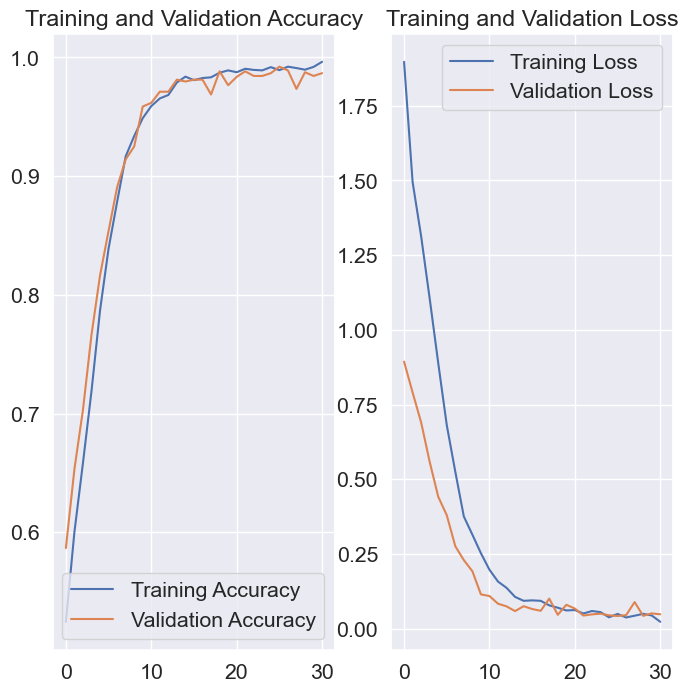

In [83]:
acc2 = model2_history.history['accuracy']
val_acc2 = model2_history.history['val_accuracy']

loss2 = model2_history.history['loss']
val_loss2 = model2_history.history['val_loss']

epochs_range2 = range(31)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range2, acc2, label='Training Accuracy')
plt.plot(epochs_range2, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range2, loss2, label='Training Loss')
plt.plot(epochs_range2, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Plot Confusion Matrix

20/20 [==============================] - 6s 315ms/step


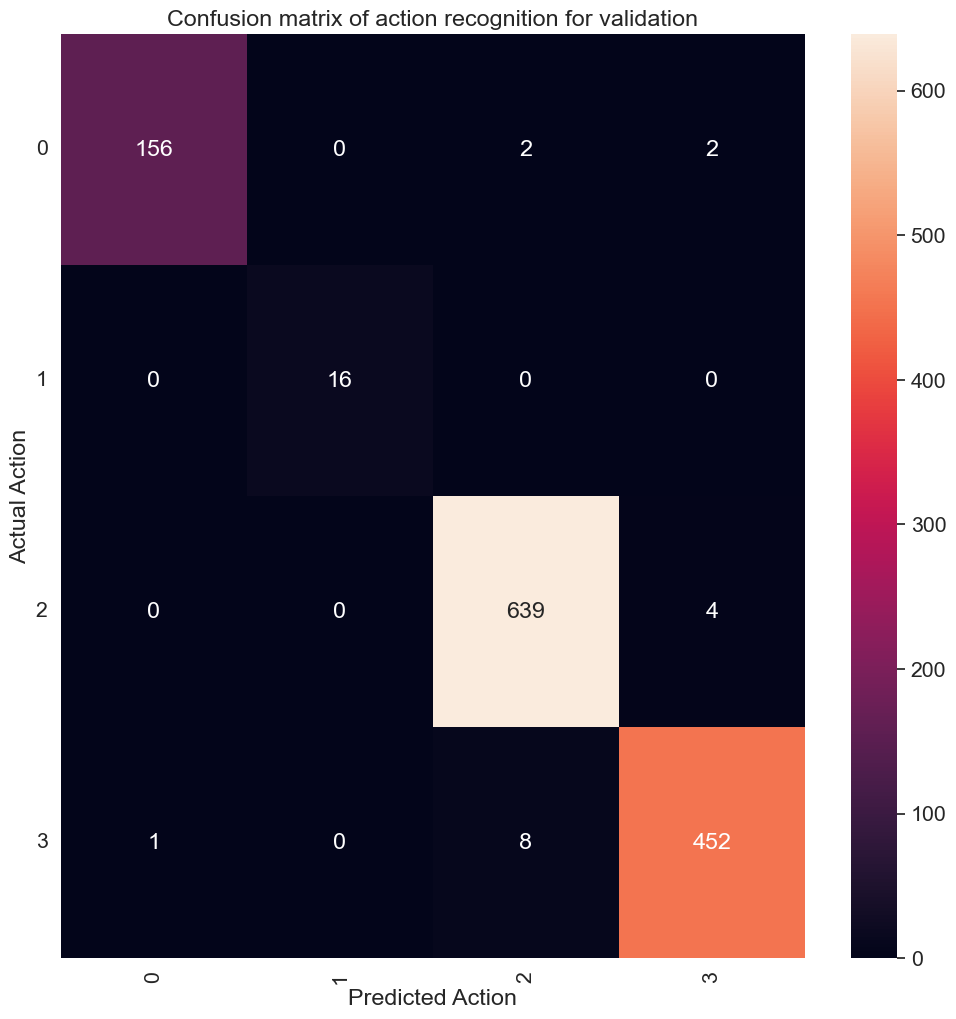

In [84]:
val_label2 = np.concatenate([y for x, y in val_ds2], axis=0)
actual2, predicted2 = get_actual_predicted_labels(val_ds2)
plot_confusion_matrix(actual2, predicted2, np.unique(val_label2), 'validation')